# Identify Surfaces

This notebook will:

* Open the SAR data
* Adjust it to the same winter means of each type (optional?)
* calculate melt season start
* calculate melt season end
* Determine if firn or bare ice
* determine if percolation
* determine if aquifer
* determine if dry snow


In [2]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX

#capture
from datetime import datetime,timedelta
from scipy import stats
import glob
import json # for loads
import os
from pathlib import Path
import pytz
import re
import shutil
import asf_search as asf
from zipfile import ZipFile
import time

from matplotlib import pyplot as plt
import matplotlib
# matplotlib.use('Agg')
#Writing Support Functions:

import numpy as np
from osgeo import gdal,osr

from IPython.display import HTML, display, clear_output, Markdown
    
from hyp3_sdk import Batch, HyP3

import opensarlab_lib as asfn

URLWidget()

In [3]:
##Set path and open data##
projdir = Path.home()/"GlacierSARdata"
projname = 'Wrangell'
year = 2020
data_dir=Path(f'{projdir}/{projname}/{str(year)}')
pols = ['VV','VH']

# Setting Paths
analysis_directory = Path.cwd()/data_dir
print(f"analysis_directory: {analysis_directory}")

download_path = analysis_directory/"rtc_download"
products_path = analysis_directory/"rtc_products"
clipped_path = analysis_directory/"rtc_clipped"

#Open metadata
usepol = 'VV'
(arraykey,pnamelist,mnamelist,mdatelist,mpflist,mpfulist) = np.load(f'{str(analysis_directory)}/imgmeta_{usepol}.npy',allow_pickle=True)
mpfunique = np.unique(mpfulist)

#Open data:
shp = np.shape(gdal.Open(pnamelist[0]).ReadAsArray())
data = np.empty(shape=[len(pnamelist),shp[0],shp[1]])
for i,name in enumerate(pnamelist):
    cdata = gdal.Open(name).ReadAsArray()
    cdata[cdata==0]=np.nan
    cdata[np.abs(cdata)>=60]=np.nan
    data[i,:]=cdata


analysis_directory: /home/jovyan/GlacierSARdata/Wrangell/2020


In [4]:
# adjust timeseries
# This will bring the timeseries to have zeros for the mean value of each pixel, BUT it will
# also have 

wstart = datetime(year,1,1,0,0,0)
wend = datetime(year,4,1,1,0,0,0)

mpfu = np.array(mpfulist)
klen,ilen,jlen = np.shape(data)
datelist = np.array(mdatelist)
if type(datelist)==tuple:
    datelist = np.array(datelist)

wmeanvals = np.zeros((len(mpfunique),ilen,jlen))
for m,mpf in enumerate(mpfunique):
    dstack = data[mpfu==mpf]     #datastack
    tlist = datelist[mpfu==mpf]  #datelist
    # print(np.shape(dstack))
    
    #dstack should data. Datelist should be list of dates.
    #Both of these should ONLY be from images of the same path-frame

    winterlist = np.zeros(len(tlist))
    winterlist[(tlist > wstart) & (tlist < wend)] = 1
    winterlist = np.array(winterlist,dtype=bool)
    dstack = dstack[winterlist]
    wmeanvals[m] = np.nanmean(dstack,axis=0)
    
wmeanmap=np.nanmean(wmeanvals,axis=0)
for m,mpf in enumerate(mpfunique):
    #to correct:
    corrmap = wmeanmap - wmeanvals[m]
    data[mpfu==mpf] += corrmap
    
    #to get winter means:
    ### data[mpfu==mpf] -= wmeanmap
    # data[mpfu==mpf] -= wmeanvals[m]
    
# plt.figure()
# plt.imshow(data[0])
# 
# plt.figure()
# plt.imshow(data[1])

/tmp/ipykernel_166/2876254092.py:27: RuntimeWarning: Mean of empty slice
  wmeanvals[m] = np.nanmean(dstack,axis=0)


## Process stuff

In [4]:
#Make meltcube
#Requires data to be corrected to winter mean of each scene above
meltth = -3 #anything below this is melt

meltcube = np.zeros(np.shape(data),dtype='bool')
meltcube[data<=meltth]=True

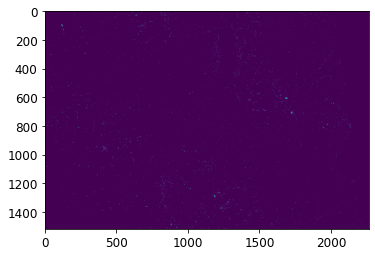

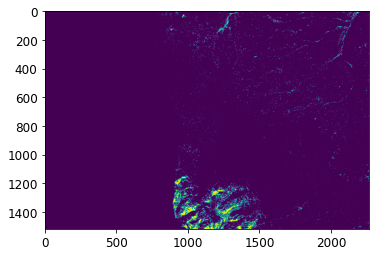

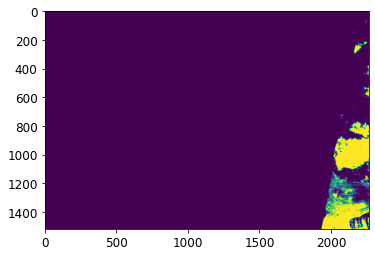

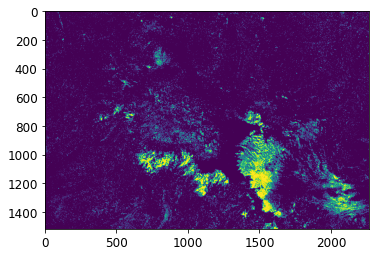

In [11]:
plt.figure()
plt.imshow(meltcube[5])

plt.figure()
plt.imshow(meltcube[35])

plt.figure()
plt.imshow(meltcube[75])

plt.figure()
plt.imshow(meltcube[115])

In [5]:
def timediff(time1,time2,form='days'):
    '''time difference between time2 and time1 expressed as either days or seconds'''
    # dd = 1
    # if time1>time2:
    #     dd=1
    diff = time2-time1
    if form=='seconds':
        diff = diff.seconds+diff.days*86400
    elif form=='days':
        diff = diff.seconds/86400+diff.days
    return diff

def meltseason(meltcube,datelist,showtime=True,):
    """will return the start date and end date of each melt season, as well as the uncertainty of each
    
    note, this is different from the function in the old script. This one takes the meltcube"""
    if type(datelist)==tuple:
        datelist = np.array(datelist)
    
    ssdn=12.1 #season stop day number. This is how many days to track to see if melt has concluded
              #This is set to 12.1 because scenes repeat exactly every 12 days
    t = time.time()
    shp = np.shape(meltcube)[1:]
    ilen,jlen = shp[0],shp[1]
    
    meltlen = np.zeros(shp)
    meltstart = np.zeros(shp,dtype='object')
    meltstartstd = np.zeros(shp)
    meltend = np.zeros(shp,dtype='object')
    meltendstd = np.zeros(shp)
    meltseanum = np.zeros(shp)  
    
    #do the processing
    for ii in range(ilen):
        for jj in range(jlen):
            meltvec = np.array(meltcube[:,ii,jj],dtype='int')
    
            useind = ~np.isnan(meltvec)
            # print(useind)
            meltvec = meltvec[useind]
            datelist = datelist[useind]

            mdiff = meltvec[1:]-meltvec[:-1]
            dstart = []
            dstartstd = []
            dend = []
            dendstd = []

            # mstartind = np.where(mdiff==1)[0][0]+1
            mstartind = np.where(mdiff==1)

            mstartind = [i+1 for i in mstartind[0]]
            # print(mstartind)
            mlen = len(meltvec)


            while len(mstartind)>0:
                mstart = mstartind[0]
                # print(mstartind)
                mstartind.remove(mstart)

                d1 = datelist[mstart-1]
                d2 = datelist[mstart]
                dstart.append( d1+(d2-d1)/2)
                dstartdiff = timediff(d1,d2)
                # dstartstd.append((d2-d1).days*0.2886751345) #This is 1/sqrt(12)
                dstartstd.append(dstartdiff*0.2886751345) #This is 1/sqrt(12)

                cind = mstart
                lastone = mstart #the last one that was seen. Not the last zero or last two.
                cdstart = dstart[-1]

                while cind < mlen-1:
                    cind+=1
                    # print(cind)
                    if meltvec[cind]==1.0:
                        lastone = cind
                        # print('still melt')
                        if cind in mstartind:
                            mstartind.remove(cind)
                    if meltvec[cind] == 0:
                        ddiff = (datelist[cind]-datelist[lastone]).days

                        if ddiff >= ssdn:
                            d1 = datelist[lastone]
                            d2 = datelist[lastone+1]
                            # d12diff = (d2-d1).days+(d2-d1).seconds/86400
                            d12diff = timediff(d1,d2)
                            dend.append( d1+timedelta(days=(d12diff)/2))
                            dendstd.append(d12diff*0.2886751345) #This is 1/sqrt(12)
                            break

                    if cind==mlen-1:
                        if meltvec[cind]==1:
                            dendstd.append(np.nan)
                            dend.append(datetime(datelist[-1].year+1,1,1))

                        else:

                            d1 = datelist[lastone]
                            d2 = datelist[lastone+1]
                            # d12diff = (d2-d1).days+(d1-d2).seconds/86400
                            d12diff = timediff(d1,d2)
                            dend.append( d1+timedelta(days=(d12diff)/2))
                            dendstd.append(d12diff*0.2886751345) #This is 1/sqrt(12)


                    # print(f'{len(dstart)} and {len(dend)}')
            if len(dstart)>len(dend):
                dend.append(datetime(datelist[-1].year+1,1,1))
                dendstd.append(np.nan)
                                                
            mlen=0
            # print(f'{len(dstart)} and {len(dend)}')
            for i,ds in enumerate(dstart):
                # mlen += (dend[i]-ds).days
                mlen += timediff(ds,dend[i])
            meltlen[ii,jj] = mlen
            if len(dstart)>0:
                meltstart[ii,jj] = dstart[0]
                meltstartstd[ii,jj] = dstartstd[0]
                meltend[ii,jj] = dend[-1]
                meltendstd[ii,jj] = dendstd[-1]
            else:
                meltstart[ii,jj] = np.nan
                meltstartstd[ii,jj] = np.nan
                meltend[ii,jj] = np.nan
                meltendstd[ii,jj] = np.nan
            
            meltseanum[ii,jj]=len(dstart)

            #do the time thing
        if ii % 10 == 0:
            if ii > 0:
                count = ii
                te = time.time()-t  #time elapsed
                print(f'Current row: {count}/{ilen}, time elapsed: {te/60:.2f} min,'
                          f' time remaining: {(te/(ii+1)*(ilen-count-1))/60:.2f} min\f',end="\r")
                
    return meltlen,meltstart,meltstartstd,meltend,meltendstd,meltseanum
    # return np.array(dstart),np.array(dend),np.array(dstartstd),np.array(dendstd)

In [6]:
meltlen,meltstart,meltstartstd,meltend,meltendstd,meltseanum = meltseason(meltcube,datelist)

In [7]:
# np.save(analysis_directory/"melt.npy", (meltlen,meltstart,meltstartstd,meltend,meltendstd,meltseanum))

In [6]:
#convert datemap to julian float date map

def juliandate(datemap,year):
    """converts a numpy object array of datetimes to julian dates"""
    yrstartdate = datetime(year,1,1)
    shp = np.shape(datemap)
    shplen = len(shp)
    if shplen==0:
        jdmap = timediff(yrstartdate,datemap)
    elif shplen==1:
        ilen = shp[0]
        jdmap = np.zeros((ilen))
        for ii in range(ilen):
            jdmap[ii]=timediff(yrstartdate,datemap[ii])
    elif shplen==2:
        ilen,jlen = shp
        jdmap = np.zeros((ilen,jlen))
        for ii in range(ilen):
            for jj in range(jlen):
                # print(datemap[ii,jj])
                cdate = datemap[ii,jj]
                # print(cdate)
                if type(cdate) == float:
                    if np.isnan(cdate):
                        jdmap[ii,jj]=np.nan
                    else:
                        print('It is something else!')
                else:
                    # jdmap[ii,jj] = (datemap[ii,jj]-yrstartdate).days
                    jdmap[ii,jj] = timediff(yrstartdate,datemap[ii,jj])
    
    return jdmap

In [14]:
safetest = np.array(meltstart)
print(safetest)
safetest = juliandate(safetest,year)
print(safetest)

[[nan nan datetime.datetime(2020, 4, 13, 9, 37, 58) ...
  datetime.datetime(2020, 9, 16, 9, 38, 7)
  datetime.datetime(2020, 12, 13, 21, 25, 48) nan]
 [nan datetime.datetime(2020, 10, 29, 3, 11, 33)
  datetime.datetime(2020, 4, 10, 21, 33, 49) ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... datetime.datetime(2020, 5, 11, 21, 25, 41, 500000)
  datetime.datetime(2020, 5, 11, 21, 25, 41, 500000)
  datetime.datetime(2020, 3, 24, 21, 25, 40)]
 [nan nan nan ... datetime.datetime(2020, 5, 19, 9, 38)
  datetime.datetime(2020, 5, 11, 21, 25, 41, 500000)
  datetime.datetime(2020, 5, 8, 9, 29, 50)]
 [nan nan nan ... datetime.datetime(2020, 5, 11, 21, 25, 41, 500000)
  datetime.datetime(2020, 1, 12, 21, 25, 40, 500000)
  datetime.datetime(2020, 4, 26, 9, 29, 50)]]
[[ nan  nan 103. ... 259. 347.  nan]
 [ nan 302. 100. ...  nan  nan  nan]
 [ nan  nan  nan ...  nan  nan  nan]
 ...
 [ nan  nan  nan ... 131. 131.  83.]
 [ nan  nan  nan ... 139. 131. 128.]
 [ nan  nan  nan ... 131

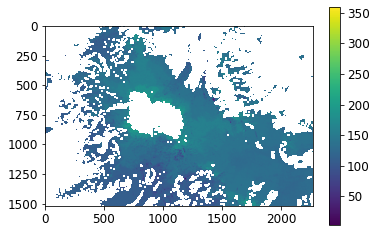

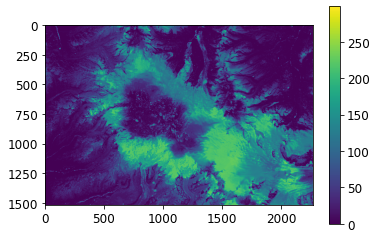

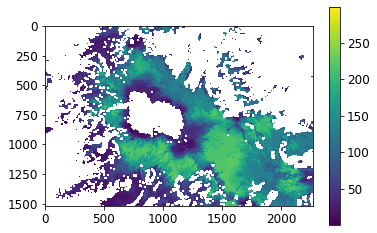

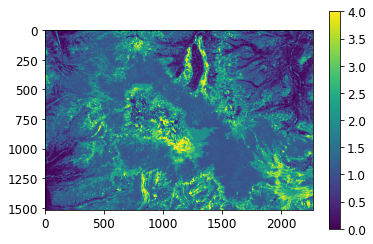

In [22]:
plt.figure()
plt.imshow(safetest)
plt.colorbar()

# meltlen = np.array(meltlen,dtype='float')
meltlensafe = np.array(meltlen,dtype='float')
meltlensafe[meltlensafe==0]=np.nan
plt.figure()
plt.imshow(meltlen)
plt.colorbar()

plt.figure()
plt.imshow(meltlensafe)
plt.colorbar()

meltseasafe = np.array(meltseanum,dtype='float')
# meltseasafe[meltseasafe==0]=np.nan
plt.figure()
plt.imshow(meltseasafe,vmax=4)
plt.colorbar()

56055


(array([2.193578e+06, 7.642790e+05, 2.951150e+05, 1.649770e+05,
        1.423500e+04, 3.997000e+03, 1.280000e+03, 3.200000e+01,
        3.000000e+00, 1.000000e+00]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <BarContainer object of 10 artists>)

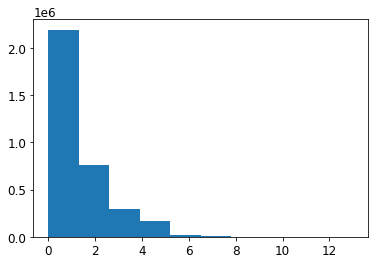

In [24]:
meltseasafe = np.array(meltseanum)
# np.unique(meltseanum[meltlen==1])
mlu = np.unique(meltlen)
# mlu[1:]-mlu[:-1]
print(len(mlu))
# len(mlu)
# type(safetest[0,0])
# print(datetime(1,1,1))
# np.nan(datetime(1,1,1))
# plt.figure()
# plt.hist(mlu)

plt.figure()
plt.hist(meltseasafe.flatten())

In [27]:
ipt,jpt = 850,1400
print(meltcube[:,ipt,jpt])
print(data[:,ipt,jpt])

# 123456 = 5

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False  True False False False False False
  True  True  True False  True  True  True False  True  True  True False
  True  True  True False  True  True  True False  True  True  True False
  True  True  True False  True  True  True False  True  True  True False
 False False False False False False False False False False False False
 False False False False False False False False False False]
[            nan -8.51436343e-01  1.15502630e-01 -1.25734874e-01
             nan -6.99095454e-01  4.89651952e-01  3.15421036e-01
             nan  6.44927297e-01  1.48592213e+00 -9.67136690e-01
             nan -7.20309939e-01 -1.30470582e+00  7.22402845e-02
             nan  4.2

In [28]:
a=np.arange(12)
a.reshape(3,4)

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [10]:
d1 = datetime(2021,7,10,0,0,0)
d2 = datetime(2021,7,5,6,32,0)
# print((d2-d1).days+(d2-d1).seconds/86400)
# timediff(d1,d2)

-4.727777777777778


-4.727777777777778

In [23]:
# np.unique(meltseasafe)
meltseasafe.flatten()

array([0., 0., 1., ..., 4., 5., 4.])

## Aquifer detection

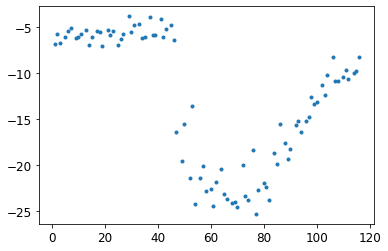

In [7]:
# identify an aq region:

# ipt,jpt = 1000,1000 #diff pt but it works
ipt,jpt = 1100,1500

plt.figure()
plt.plot(data[:,ipt,jpt],'.')

How the AQ detection works:

1. find the winter time period you want. Say, Oct 1 to dec 31.
2. test a lin regression on it. Perhaps, you could look at a map of slopes and corr coeffs for this
3. See how long it takes to do a lin regress on the whole danggone area. You could cut it down my using a melt mask.
4. You should use that melt mask.
5. If doing lin regress is fast, then do that
6. If all the areas look linear with good corr coeff, then use that
7. In fact, if the areas all have a similar slope, even better, because you could just test the fit to that. Probably not though. Just use linear algebra.

0.0
0


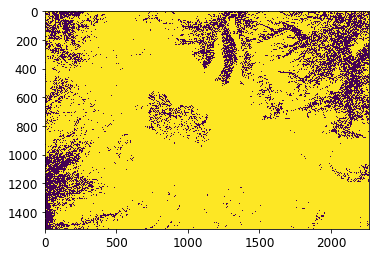

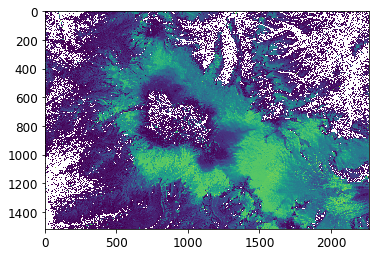

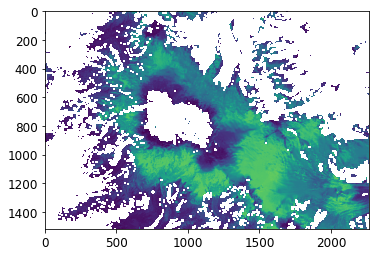

In [8]:
#linear algebra. Make slope and corr maps

#get mask:
(meltlen,meltstart,meltstartstd,meltend,meltendstd,meltseanum) = np.load(analysis_directory/"melt.npy",allow_pickle=True)

mask = np.ones(np.shape(meltlen),dtype='bool')
mask[meltlen==0]=False

plt.figure()
plt.imshow(mask,interpolation='nearest')

meltlensafe = np.array(meltlen,dtype='float')
meltlensafe[meltlensafe==0]=np.nan
print(np.nansum(meltlensafe[~mask]))
print(np.nansum(mask[meltlensafe==0]))

plt.figure()
plt.imshow(meltlensafe,interpolation='nearest')

plt.figure()
plt.imshow(meltlensafe)#,interpolation='nearest')

In [17]:
# 

dtype('O')

In [46]:
fallstart = datetime(year,10,1)
fallend = datetime(year+1,1,1)

print(juliandate(fallstart,year))
# help(stats.linregress)

274.0


In [51]:
# juliandate(datelist,year)

array([  2.65840278,   7.13858796,   7.66416667,   9.12726852,
        14.6583912 ,  19.13857639,  19.66415509,  21.12725694,
        26.6583912 ,  31.13857639,  31.66415509,  33.12725694,
        38.6583912 ,  43.13857639,  43.66415509,  45.12725694,
        50.65837963,  55.13856481,  55.66414352,  57.12724537,
        62.65837963,  67.13856481,  67.66415509,  69.12724537,
        74.65837963,  79.13857639,  79.66415509,  81.12725694,
        86.6583912 ,  91.13857639,  91.66415509,  93.12725694,
        98.6583912 , 103.13857639, 103.66415509, 105.12725694,
       110.6583912 , 115.13858796, 115.66416667, 117.12726852,
       122.65840278, 127.13858796, 127.66416667, 129.12726852,
       134.65841435, 139.13859954, 139.66417824, 141.12728009,
       146.65841435, 151.13861111, 151.66418981, 158.65842593,
       163.13861111, 163.66420139, 165.12730324, 170.6584375 ,
       175.13862269, 175.66420139, 177.12730324, 182.6584375 ,
       187.13863426, 187.66421296, 189.12731481, 194.65

In [44]:
np.shape(datelist)[0]

118

In [50]:
np.zeros((5))

array([0., 0., 0., 0., 0.])

274.0
366.0
[283.13868056 283.66425926 285.12736111 295.66425926 297.12736111
 307.13868056 307.66425926 309.12736111 319.13868056 319.66425926
 321.12736111 331.13868056 331.66425926 333.12736111 343.13866898
 343.66424769 345.12734954 355.13865741 355.66424769 357.12733796]
20
20


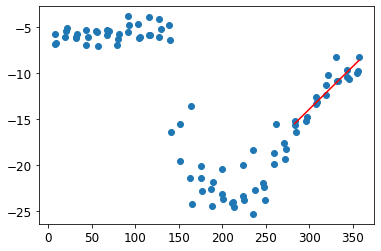

In [41]:
fallstart = datetime(year,10,1)
fallend = datetime(year+1,1,1)

ipt,jpt = 1000,1000
ipt,jpt = 1100,1500
# ipt,jpt = 300,750
juldates = juliandate(datelist,year)
dvec = np.array(data[:,ipt,jpt])
datevec = np.array(juldates)

datevec = datevec[~np.isnan(dvec)]
dvec = dvec[~np.isnan(dvec)]
# print(len(datevec))
# print(len(dvec))
# print(datevec)
# print(dvec)

fallstart = juliandate(fallstart,year)
fallend = juliandate(fallend,year)

print(fallstart)
print(fallend)

dvec = dvec[(datevec >= fallstart) & (datevec <= fallend)]
datevec = datevec[(datevec >= fallstart) & (datevec <= fallend)]
# datevec[(datevec >= fallstart) & (datevec <= fallend)])

print(datevec)
print(len(dvec))
print(len(datevec))
# print(datevec[(datevec >= fallstart) & (datevec <= fallend)])

res = stats.linregress(datevec,dvec)

plt.figure()
plt.plot(juldates, data[:,ipt,jpt], 'o', label='original data')
plt.plot(datevec, res.intercept + res.slope*datevec, 'r', label='fitted line')

In [47]:
#lin regress map

fsmap = np.zeros(np.shape(meltlen))
fsmap[~mask]=np.nan
iipts,jjpts = np.where(mask==1)
fullcount = iipts[0]
# print(upts)


(array([   0,    0,    0, ..., 1518, 1518, 1518]), array([   2,    4,    5, ..., 2260, 2261, 2262]))


In [51]:
# # np.shape(mask)
# # 1519*2263
# a=np.arange(12)
# a=a.reshape(3,4)
# np.where(a>6)

(array([1, 2, 2, 2, 2]), array([3, 0, 1, 2, 3]))

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])